## Conductividad térmica

Solo uso el modelo de Toegel, no sé si funciona bien el modelo de Yasui porque no lo estoy usando

### Importo dependencias

In [39]:
#Importo librerías
import math
import numpy as np

In [40]:
#Código necesario para importar funciones de otros notebooks .ipynb

import io, os, sys, types
from IPython import get_ipython
from nbformat import read
from IPython.core.interactiveshell import InteractiveShell

def find_notebook(fullname, path=None):
    """find a notebook, given its fully qualified name and an optional path

    This turns "foo.bar" into "foo/bar.ipynb"
    and tries turning "Foo_Bar" into "Foo Bar" if Foo_Bar
    does not exist.
    """
    name = fullname.rsplit('.', 1)[-1]
    if not path:
        path = ['']
    for d in path:
        nb_path = os.path.join(d, name + ".ipynb")
        if os.path.isfile(nb_path):
            return nb_path
        # let import Notebook_Name find "Notebook Name.ipynb"
        nb_path = nb_path.replace("_", " ")
        if os.path.isfile(nb_path):
            return nb_path

class NotebookLoader(object):
    """Module Loader for Jupyter Notebooks"""
    def __init__(self, path=None):
        self.shell = InteractiveShell.instance()
        self.path = path

    def load_module(self, fullname):
        """import a notebook as a module"""
        path = find_notebook(fullname, self.path)

        print ("importing Jupyter notebook from %s" % path)

        # load the notebook object
        with io.open(path, 'r', encoding='utf-8') as f:
            nb = read(f, 4)


        # create the module and add it to sys.modules
        # if name in sys.modules:
        #    return sys.modules[name]
        mod = types.ModuleType(fullname)
        mod.__file__ = path
        mod.__loader__ = self
        mod.__dict__['get_ipython'] = get_ipython
        sys.modules[fullname] = mod

        # extra work to ensure that magics that would affect the user_ns
        # actually affect the notebook module's ns
        save_user_ns = self.shell.user_ns
        self.shell.user_ns = mod.__dict__

        try:
          for cell in nb.cells:
            if cell.cell_type == 'code':
                # transform the input to executable Python
                code = self.shell.input_transformer_manager.transform_cell(cell.source)
                # run the code in themodule
                exec(code, mod.__dict__)
        finally:
            self.shell.user_ns = save_user_ns
        return mod


class NotebookFinder(object):
    """Module finder that locates Jupyter Notebooks"""
    def __init__(self):
        self.loaders = {}

    def find_module(self, fullname, path=None):
        nb_path = find_notebook(fullname, path)
        if not nb_path:
            return

        key = path
        if path:
            # lists aren't hashable
            key = os.path.sep.join(path)

        if key not in self.loaders:
            self.loaders[key] = NotebookLoader(path)
        return self.loaders[key]

sys.meta_path.append(NotebookFinder())

#Ejemplo
# from derivada_reacciones import *

In [41]:
#Importo notebooks
from parametros import *
from funciones_math import erf, fact, Vol
from funciones_qcas import *


from parametros import masa_H2O_kgmol, Na, n_species, K, var_termo
from parametros import alfaM, Rv
from parametros import mpmin, mpmax, epsilon, Tmin, Tmax

from parametros import a_Ar, b_Ar, a_h2o, b_h2o

from funciones_qcas import n_tot, masa_media_por_particula
from parametros import Rg, pvap0



### Modelos para calcular TB

In [42]:
#Importo los valores de conductividad térmica

def Conductividad1(k1):
    #funcion que asigna el termino independiente de la conductividad de cada especie
    #k=k1+k2*T

    k1[0]=k1H2 #Antes k1[0]
    k1[1]=k1H #Antes k1[1]
    k1[2]=k1O #Antes k1[2]
    k1[3]=k1O2 #Antes k1[3]
    k1[4]=k1OH #Antes k1[4]
    k1[5]=k1h2o #Antes k1[5]
    #    k1[7]=k1N
    #    k1[8]=k1NH
    #    k1[9]=k1NH2
    #    k1[10]=k1NH3
    #    k1[11]=k1N2H
    #    k1[12]=k1NO
    #    k1[13]=k1NO2
    #    k1[14]=k1N2H
    #    k1[15]=k1HNO
    #    k1[16]=k1N2
    #    k1[17]=k1Ar
    k1[6]=k1h2o #Antes k1[18]
    k1[7]=k1h2o #Antes k1[19]


def Conductividad2(k2):
    #funcion que asigna el termino lineal de la conductividad de cada especie
    #k=k1+k2*T

    k2[0]=k2H2 #Antes k2[1]
    k2[1]=k2H #Antes k2[2]
    k2[2]=k2O #Antes k2[3]
    k2[2]=k2O2 #Antes k2[4]
    k2[4]=k2OH #Antes k2[5]
    k2[5]=k2h2o #Antes k2[6]
    # k2[7]=k2N
    # k2[8]=k2NH
    # k2[9]=k2NH2
    # k2[10]=k2NH3
    # k2[11]=k2N2H
    # k2[12]=k2NO
    # k2[13]=k2NO2
    # k2[14]=k2N2H
    # k2[15]=k2HNO
    # k2[16]=k2N2
    # k2[17]=k2Ar
    k2[6]=k2h2o #Antes k2[18]
    k2[7]=k2h2o #Antes k2[19]

def Conductividad_termica_k(y3,n):
    #Calcula la conductividad térmica k que aparece en la ec. 2.2.9.1.1

    k=0.0

    k1 = np.zeros(n_species)
    k2 = np.zeros(n_species)
    Conductividad1(k1)
    Conductividad2(k2)

    ntot = n_tot(n)

    k = np.dot((k1 + k2*y3),n)/ntot

    # for i in range(n_species):
    #     k=k+(k1[i]+k2[i]*y3)*n[i]/ntot

    return k


In [43]:
def landa(Vol, sigmap, ntot):
    #Calcula el camino libre medio
    #Vol: volumen
    #sigmap: sigma_prima es la sección eficaz de una molécula en la burbuja
    #ntot: nro total de partículas

    return Vol/(math.sqrt(2.0)*sigmap*ntot)


#### Modelo de Yasui

No lo uso así que no revisé si está bien implementado

In [44]:
#metodo de Yasui
def calculaT_biY(Tmin, Tmax, epsilon, TLi, k, landa, np_, T, m):
    #Calcula TB a partir del método de Yasui empleando la expresión 2.2.1.10. Para calcular q'' utiliza la expresión 2.2.9.1.1

    #Para hacer biseccion usa un Tmin y un Tmax, a partir de los cuales hace los calculos
    #epsilon es la tolerancia para encontrar la raiz por el metodo de biseccion
    #TLi es la temperatura en la pared de la burbuja del lado externo
    #k es la conductividad que depende de la temperatura
    #landa es una funcion que depende de la temperatura
    #np_ es la densidad de numero de moleculas
    #T es la temperatura en el interior de la burbuja


    while((Tmax-Tmin)>epsilon):

        f1=Tmax-TLi+1.0/(2.0*K*np_)*math.sqrt(3.14159*m/(2.0*K*Tmax))*(2.0-ap*alfae)/alfae*k*(Tmax-T)/(n_Yasui*landa)

        x=(Tmax+Tmin)/2.0

        f3=x-TLi+1.0/(2.0*K*np_)*math.sqrt(3.14159*m/(2.0*K*x))*(2.0-ap*alfae)/alfae*k*(x-T)/(n_Yasui*landa)
        if(f1*f3>0):
            Tmax=x
        else:
            Tmin=x

    return x


#### Modelo de Toegel

Este modelo es el que nos importa

In [45]:
def calcula_Xi(k, nh2o0, ngas):
    #Calcula Xi
    # Xi=k/(8.0/2.0*nh2o0*K+5.0/2.0*nAr*K)
    # Xi=k/(8.0/2.0*nh2o0*K)

    # R0 = 0.010263277913696248*(1/100)
    # V0 = Vol(R0)

    denominador = (8.0/2.0*nh2o0*K +5.0/2.0*ngas*K)
    Xi=k/denominador

    return Xi

In [46]:
import math
pi = math.pi
from parametros import ap, alfae, Tinf

In [55]:
def longitud_termica(y,k,nh2o0, ngas):
  #Calcula la longitud térmica lth necesaria para calcular T_B mediante el método de Toegel
  #y: conjunto de variables termodinámicas
  #k: conductividad térmica
  #nh2o0: número de partículas de H2O en t = 0
  #nAr: número de partículas de Ar

  #Asigno las variables termodinámicas
  R = y[var_termo["R"]]
  v_R = y[var_termo["v_R"]]
  
  #Calculo Xi
  Xi = calcula_Xi(k,nh2o0, ngas)


  if(v_R == 0):
    lth=R/pi
  else:
    a = (R/pi)
    b = np.sqrt(R*Xi/abs(v_R))
    if(a<b):
      lth=a
    else:
      lth=b
  return lth


#metodo de Toegel
# def calculaT_biT(Tmin, Tmax, epsilon, TLi, k, lth, np_, T, m):

#   #Para hacer biseccion usa un Tmin y un Tmax, a partir de los cuales hace los calculos
#   #epsilon es la tolerancia para encontrar la raiz por el metodo de biseccion
#   #TLi es la temperatura en la pared de la burbuja del lado externo
#   #k es la conductividad que depende de la temperatura
#   #landa es una funcion que depende de la temperatura
#   #np_ es la densidad de numero de moleculas. Tuve que cambiarlo a np_ en lugar de np porque Python me lo confundía con Numpy
#   #T es la temperatura en el interior de la burbuja

#   while((Tmax-Tmin)>epsilon):

#     f1=Tmax-TLi+1.0/(2.0*K*np_)*math.sqrt(3.14159*m/(2.0*K*Tmax))*(2.0-ap*alfae)/alfae*k*(Tinf-T)/(lth)

#     x=(Tmax+Tmin)/2.0

#     f3=x-TLi+1.0/(2.0*K*np_)*math.sqrt(3.14159*m/(2.0*K*x))*(2.0-ap*alfae)/alfae*k*(Tinf-T)/(lth)


#     if(f1*f3>0):
#       Tmax=x
#     else:
#       Tmin=x
  

#   return x

# from scipy.optimize import fsolve #Para resolver ecuaciones algebraicas

# def calculaT_biT(Tmin, Tmax, epsilon, TLi, k, lth, np_, T_bc, m):

#     def eq(T_bi):
#         return TLi-1.0/(2.0*K*np_)*np.sqrt(3.14159*m/(2.0*K*T_bi))*(2.0-ap*alfae)/alfae*k*(Tinf-T_bc)/(lth) - T_bi

#     return fsolve(eq, T_bc)[0]

def calculaT_biT(Tmin, Tmax, epsilon, TLi, k, lth, np_, T_bc, m):
  return (TLi + T_bc)/2

In [48]:
from presion import p_g
from funciones_qcas import n_gas

### mp (m_punto)

In [49]:
#Función que calcula m_punto.

def calculamp_formal(mpmin,mpmax,epsilon, pvap, pv,T,TLi,T_bi):
   # Calcula m_punto formalmente a partir de la expresión 2.2.1.3 considerando varios factores como entrada
   # mpmin y mpmax son parámetros mínimos y máximos para el cálculo por bisección. Están definidos en Parámetros
   # epsilon es la tolerancia para el cálculo por bisección. Está definida en Parámetros
   # pvap es la presión de vapor saturado a la temperatura del líquido en la interfase T_{L,i}. Está definida en parámetros
   # pv es la presión parcial correspondiente al vapor
   
   # T ((creo que es la temperatura de la burbuja))
   # TLi es la temperatura del líquido en la interfase
   # T_bi es la temperatura de la mezcla en la superficie de la burbuja

   if(alfaM > 0):
      while ((mpmax-mpmin)>epsilon):
         #mp es la resta de los mp de evaporacion y de condensacion
         Omega=mpmax/pv*math.sqrt(Rv*T/2.0)
         Gama=np.exp(-Omega*Omega)-Omega*math.sqrt(3.14159)*(1.0-erf(Omega))
         f1=mpmax-alfaM/math.sqrt(2.0*3.14159*Rv)*(pvap/math.sqrt(TLi)-Gama*pv/math.sqrt(T_bi))

         x=(mpmin+mpmax)/2.0

         Omega=x/pv*math.sqrt(Rv*T/2.0)
         Gama=np.exp(-Omega*Omega)-Omega*math.sqrt(3.14159)*(1.0-erf(Omega))

         f3=x-alfaM/math.sqrt(2.0*3.14159*Rv)*(pvap/math.sqrt(TLi)-Gama*pv/math.sqrt(T_bi))

         if(f1*f3>0):
            mpmax=x
         else:
            mpmin=x
      #fin del while

      return x
      #devuelve el valor de mp como la raiz de la ecuacion trascendente con tolerancia epsilon
   #fin del if
   else:
      x=0
      return x


def calculamp(y, n, rapidez, nh2o0):
   # Calcula m_punto y T_bi a partir de la expresión 2.2.1.3. Calcula también las variables necesarias para hacer la cuenta
   # rapidez indica si se quiere hacer la cuenta rápido o lento. Esencialmente, lo único que cambia es si va a calcular la función error o no.
   # T_bi es la temperatura de la mezcla en la superficie de la burbuja
   
   #Asigno variables termodinámicas
   R = y[var_termo["R"]]
   T_li = y[var_termo["T_li"]]
   T_bc = y[var_termo["T_bc"]]

   #Calculo el nro total de partículas
   ntot = n_tot(n)
   n_H2O = n[5] #nro de partículas de H2O

   #Calculo el nro de partículas de gas no condensable
   ngas = n_gas(n)

   #Calculo la presión del gas
   pg = p_g(n, Vol(R), T_bc)

   #NO SÉ LO QUE ES ESTO NI SIQUIERA SI SE USA:
   # pgg=ngas/ntot*pg

   pvap=pvap0 #parámetro definido en Parámetros

   #Presion parcial del vapor de agua. Se calcula con 2.2.1.6 a partir del nro de partículas de vapor (agua), el nro total de partículas y la presión total dentro de la burbuja
   pv=n_H2O/ntot*pg 

   #Calculo T_bi: existen distintos modelos pero primero calculo las variables que afectan a todos ellos
   k = Conductividad_termica_k(T_bc,n)
   landa_ = landa(Vol(R), sigmap, ntot)
   np_=ntot/Vol(R) #tuve que cambiarle el nombre a np_ porque si no Python creía que estaba llamando al paquete np Numpy
   m = masa_media_por_particula(n)

   if(modelo == 1):
      T_bi= calculaT_biY(Tmin,Tmax,epsilon,T_li,k,landa_,np_,T_bc,m)
   if(modelo == 2):
      lth = longitud_termica(y,k,nh2o0, ngas)
      T_bi= calculaT_biT(Tmin,Tmax,epsilon,T_li,k,lth,np_,T_bc,m)
      # print(T_li, np_, m, T_bc, lth, k)

   #Hago el cálculo de mp dependiendo del parámetro rapidez. Esto afecta en la rapidez del cálculo
   if(rapidez==1):
      #tengo que hacer esto para que la función math.sqrt() tenga como argumento un nro y no una función TLi(t).
      mp=alfaM/math.sqrt(2.0*3.14159*Rv)*(pvap/math.sqrt(T_li)-pv/math.sqrt(T_bi))
   else:
      mp=calculamp_formal(mpmin,mpmax,epsilon,pvap,pv,T_bc,T_li,T_bi)
   
   return mp, T_bi

207343.47618162623

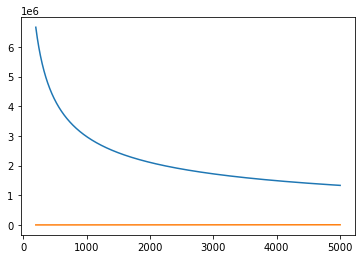

In [52]:
#Test de calculaT_biT
#Internamente la función hace la cuenta

# from parametros import ap, alfae, Tinf


# def test_T_biT(T_bi, TLi, np_, m, T_bc, lth, k):
#     return TLi-1.0/(2.0*K*np_)*np.sqrt(3.14159*m/(2.0*K*T_bi))*(2.0-ap*alfae)/alfae*k*(Tinf-T_bc)/(lth)



#Con valores típicos


test_Tli = 308.15 
test_np_ = 2.2082748354000506e+21 
test_m = 3.325595391762315e-26 
test_T_bc = 5000.0 
test_lth = 3.266902824581265e-05 
test_k = 0.5547500000000001

#Varío T_bi y grafico
# T_bi = np.linspace(200, 5000, 1000)
# test_T_biT_array = np.zeros(len(T_bi))
# for i in range(len(T_bi)):
#     test_T_biT_array[i] = test_T_biT(T_bi[i], test_Tli, test_np_, test_m, test_T_bc, test_lth, test_k)

# import matplotlib.pyplot as plt
# plt.plot(T_bi, test_T_biT_array)
# plt.plot(T_bi, T_bi)



In [54]:
# #Resuelvo con bisección:

T_bi= calculaT_biT(Tmin,Tmax,epsilon,test_Tli,test_k,test_lth,test_np_,test_T_bc,test_m)
print("Por bisección: ", T_bi)
#Resuelvo con fsolve:

from scipy.optimize import fsolve #Para resolver ecuaciones algebraicas

def test2_T_biT(TLi, np_, m, T_bc, lth, k):

    def eq(T_bi):
        return TLi-1.0/(2.0*K*np_)*np.sqrt(3.14159*m/(2.0*K*T_bi))*(2.0-ap*alfae)/alfae*k*(Tinf-T_bc)/(lth) - T_bi

    return fsolve(eq, T_bc)[0]

print("Por fsolve: ", test2_T_biT(test_Tli, test_np_, test_m, test_T_bc, test_lth, test_k))


Por bisección:  500.00000052386895
207343.47618162623
